### Importamos librerias

In [262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.svm import SVC
from scipy import stats
%matplotlib inline

### Cargamos datasets

In [263]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [264]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### Reemplazamos valores nulos en las columnas de Age,Fare y Embarked

In [265]:
df.Age.fillna(value=df.Age.mean(), inplace=True)
df.Fare.fillna(value=df.Fare.mean(), inplace=True)
df.Embarked.fillna(value=df['Embarked'].value_counts().idxmax(), inplace=True)

df_test.Age.fillna(value=df_test.Age.mean(), inplace=True)
df_test.Fare.fillna(value=df_test.Fare.mean(), inplace=True)
df_test.Embarked.fillna(value=df_test['Embarked'].value_counts().idxmax(), inplace=True)

### Split al nombre de la persona para obtener el titulo que tiene. Ej(Mr,Mrs,Master...etc)

In [266]:
titulo = pd.DataFrame(df.apply(lambda x: x.Name.split(",")[1].split(".")[0], axis=1), columns=["Titulo"])
df = df.join(titulo)

titulo = pd.DataFrame(df_test.apply(lambda x: x.Name.split(",")[1].split(".")[0], axis=1), columns=["Titulo"])
df_test = df_test.join(titulo)

df['Titulo'] = df['Titulo'].str.strip()
df_test['Titulo'] = df_test['Titulo'].str.strip()

In [267]:
df['Titulo'] = df['Titulo'].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don','Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Otro')

df_test['Titulo'] = df_test['Titulo'].replace(['Lady','the Countess', 'Countess','Capt', 'Col','Don','Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Otro')


df['Titulo'] = df['Titulo'].replace('Mlle', 'Miss')
df['Titulo'] = df['Titulo'].replace('Ms', 'Miss')
df['Titulo'] = df['Titulo'].replace('Mme', 'Mrs')

df_test['Titulo'] = df_test['Titulo'].replace('Mlle', 'Miss')
df_test['Titulo'] = df_test['Titulo'].replace('Ms', 'Miss')
df_test['Titulo'] = df_test['Titulo'].replace('Mme', 'Mrs')

### Eliminamos columnas irrelevantes para la prediccion

In [268]:
df = df.drop(['Name','Ticket','Cabin','PassengerId'],axis=1)
df_test = df_test.drop(['Name','Ticket','Cabin','PassengerId'],axis=1)

In [269]:
df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

### Aplicamos One Hot Encoding a variables categoricas y tambien numerizacion

In [270]:
dfDummies = pd.get_dummies(df['Sex'], prefix = 'Sex')
df  =  pd.concat([df,dfDummies],axis=1)

dfDummies = pd.get_dummies(df_test['Sex'], prefix = 'Sex')
df_test  =  pd.concat([df_test,dfDummies],axis=1)

In [271]:
df = df.drop('Sex',axis=1)
df_test = df_test.drop('Sex',axis=1)

In [272]:
dfDummies = pd.get_dummies(df['Embarked'], prefix = 'Embarked')
df  =  pd.concat([df,dfDummies],axis=1)

dfDummies = pd.get_dummies(df_test['Embarked'], prefix = 'Embarked')
df_test  =  pd.concat([df_test,dfDummies],axis=1)

In [273]:
df = df.drop('Embarked',axis=1)
df_test = df_test.drop('Embarked',axis=1)

In [274]:
dfDummies = pd.get_dummies(df['Titulo'], prefix = 'Titulo')
df  =  pd.concat([df,dfDummies],axis=1)

dfDummies = pd.get_dummies(df_test['Titulo'], prefix = 'Titulo')
df_test  =  pd.concat([df_test,dfDummies],axis=1)

In [275]:
df = df.drop('Titulo',axis=1)
df_test = df_test.drop('Titulo',axis=1)

### Se unifican las variables SibSp y Parch para manejar un solo dato como el total de miembros de la familia

In [276]:
total_fam = pd.DataFrame(df.apply(lambda x: x.SibSp+x.Parch, axis=1), columns=["total_fam"])
df = df.join(total_fam)

total_fam = pd.DataFrame(df_test.apply(lambda x: x.SibSp+x.Parch, axis=1), columns=["total_fam"])
df_test = df_test.join(total_fam)

In [277]:
df = df.drop(['SibSp','Parch'],axis=1)
df_test = df_test.drop(['SibSp','Parch'],axis=1)

### Que columnas tenemos y como se correlacionan entre si.

In [278]:
df.columns

Index(['Survived', 'Pclass', 'Age', 'Fare', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Titulo_Master',
       'Titulo_Miss', 'Titulo_Mr', 'Titulo_Mrs', 'Titulo_Otro', 'total_fam'],
      dtype='object')

In [279]:
df_test.columns

Index(['Pclass', 'Age', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Titulo_Master', 'Titulo_Miss', 'Titulo_Mr',
       'Titulo_Mrs', 'Titulo_Otro', 'total_fam'],
      dtype='object')

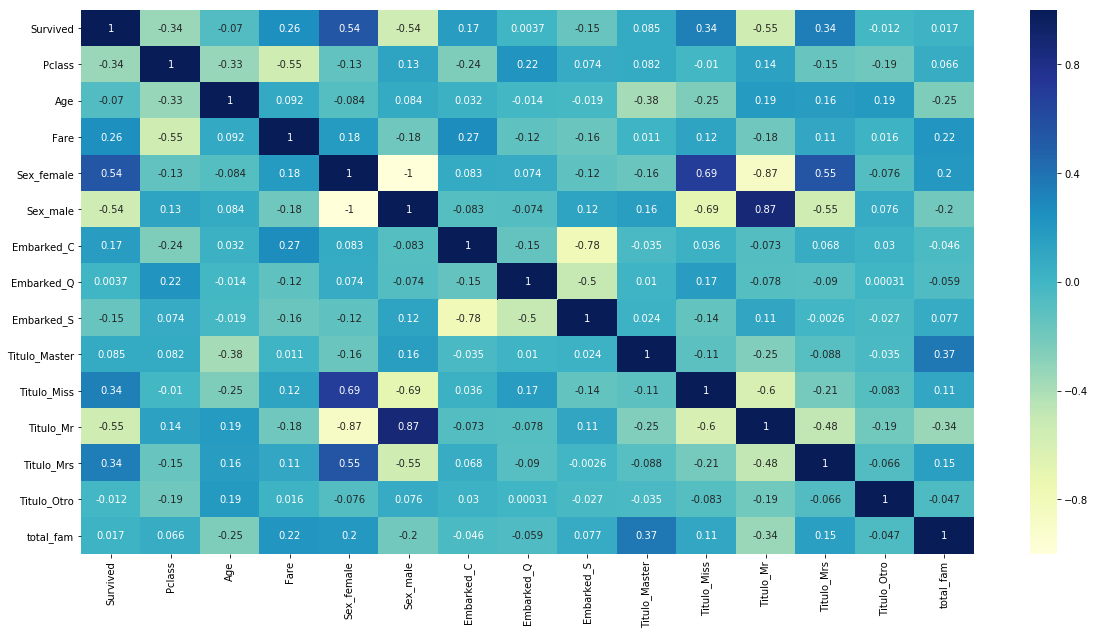

In [280]:
corr = df.corr() 
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, cmap="YlGnBu", annot=True) 

### Convertir los datos a una unica escala

In [281]:
X = df.drop('Survived',axis=1).values
y = df['Survived'].values

X_testing = df_test.values

In [282]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_testing = scaler.fit_transform(X_testing)

In [283]:
X_testing.shape

(418, 14)

In [284]:
#pca = PCA(n_components=None)
#X = pca.fit_transform(X)
#X_testing = pca.fit_transform(X_testing)

In [285]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y)

In [286]:
print("La forma de entrenamiento es {}".format(X_train.shape))
print("La forma de test es {}".format(X_test.shape))

La forma de entrenamiento es (623, 14)
La forma de test es (268, 14)


# Usamos SVC como primer modelo

In [287]:
model_1 = SVC()
param_grid = {"C": np.arange(2,20),
              "gamma":  np.logspace(-3, 2, 6),
              "kernel": ['linear','rbf']}
rs_SVC = RandomizedSearchCV(model_1,param_distributions=param_grid, n_iter=20, cv=5, n_jobs=4)
rs_SVC.fit(X_train,y_train)

/home/alarconc/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=4,
          param_distributions={'C': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]), 'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]), 'kernel': ['linear', 'rbf']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [288]:
rs_SVC.best_score_

0.8218298555377207

In [289]:
model_1 = rs_SVC.best_estimator_
model_1.fit(X_train,y_train)
model_1.score(X_test,y_test)

0.8619402985074627

In [290]:
y_pred = model_1.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[148  17]
 [ 20  83]]
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       165
           1       0.83      0.81      0.82       103

   micro avg       0.86      0.86      0.86       268
   macro avg       0.86      0.85      0.85       268
weighted avg       0.86      0.86      0.86       268



# Usamos Random Forest como modelo

In [291]:
rfc=RandomForestClassifier(random_state=42)

In [292]:
param_grid = {"n_estimators":np.arange(200,500),
              "max_features": ['auto', 'sqrt', 'log2'],
             "max_depth":np.arange(1,10),
              "criterion" :['gini', 'entropy']
             }

In [293]:
rs_RDC = RandomizedSearchCV(estimator=rfc,param_distributions=param_grid,n_iter=20, cv=5, n_jobs=4)
rs_RDC.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=4,
          param_distributions={'n_estimators': array([200, 201, ..., 498, 499]), 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]), 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [294]:
model_2 = rs_RDC.best_estimator_

In [295]:
rs_RDC.best_score_

0.8218298555377207

In [296]:
model_2.score(X_test,y_test)

0.8470149253731343

In [297]:
model_2.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=224, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [298]:
y_pred2 = model_2.predict(X_test)

In [299]:
print(confusion_matrix(y_test,y_pred2))
print(classification_report(y_test,y_pred2))

[[149  16]
 [ 25  78]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       165
           1       0.83      0.76      0.79       103

   micro avg       0.85      0.85      0.85       268
   macro avg       0.84      0.83      0.84       268
weighted avg       0.85      0.85      0.85       268



# Probando con datos de test

In [308]:
y_pred_testing = model_2.predict(X_testing)

In [309]:
df_test = pd.read_csv('test.csv')

In [310]:
submission = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": y_pred_testing
    })

In [311]:
submission.to_csv("submission.csv",index=False)